In [101]:
from smap.archiver.client import SmapClient                                                                                                                                                                                                                                                                                   
from smap.contrib import dtutil                                                                                                                                                                                                                                                                                               
import json                                                                                                                                                                                                                                                                                                                   
import sys      
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
# fetch data
c = SmapClient("http://new.openbms.org:8079")                                                                                                                                                                                                                                                                                 
uuid_file = "SDH_floor_4_temperature_uuids.json"                                                                                                                                                                                                                                                                                                      
start_time = dtutil.dt2ts(dtutil.strptime_tz("10-30-2016", "%m-%d-%Y"))                                                                                                                                                                                                                                                       
end_time = dtutil.dt2ts(dtutil.strptime_tz("11-30-2016", "%m-%d-%Y"))                                                                                                                                                                                                                                                         
                                                                                                                                                                                                                                                                                                                              
print uuid_file                                                                                                                                                                                                                                                                                                               
uuids = json.load(open(uuid_file))
data = c.data_uuid(uuids, start_time, end_time,limit=100000)


SDH_floor_4_temperature_uuids.json

downloaded 2955854b from 30 urls in 2.137s (1.384MB/s download: 2.136s, parse: 0.233522s)


In [124]:
metadata_file = 'SDH_floor_4_metadata.json'
_metadata = json.load(open(metadata_file))
metadata = {}
for doc in _metadata:
    metadata[doc['uuid']] = doc
    metadata[doc['Metadata']['Instrument']['PartNumber']] = doc

def uuid_to_ketiid(uuid):
    return metadata[uuid]['Metadata']['Instrument']['PartNumber']

In [125]:
# build data frames
temperatures = {}
for uuid, datas in zip(uuids, data):             
    if len(datas) == 0: continue
    df = pd.DataFrame.from_records(datas)
    df = df.set_index(pd.to_datetime(df.pop(0), unit='ms'))
    df = df.resample('5min').mean()
    df.columns = [uuid_to_ketiid(uuid)]
    temperatures[uuid] = df
    print uuid, df.count()

0bfbd947-40a2-5454-a352-1375790c604d 1707    4763
dtype: int64
19dac044-e8ae-5ed4-a789-a46d2cd9d375 1709    7949
dtype: int64
1f17fd93-8009-5153-926f-54395c421d93 1715    162
dtype: int64
27e71c02-6a7c-5d29-9d7e-3b437f9f6c46 1706    6128
dtype: int64
2a756197-f1b3-56eb-ab87-a61111bdd80b 1624    438
dtype: int64
2e22715f-9d3e-5c5d-b90c-8b6226e29cca 1712    7960
dtype: int64
31e75b66-41bf-518d-a144-f3e144f396e5 1713    7963
dtype: int64
3d4496b0-63e8-5d88-890a-cbce6f1202a6 1716    7962
dtype: int64
41d4673c-0926-5c58-91a3-7c440ed6962c 1631    1854
dtype: int64
4fa00ebf-6387-5183-b987-2b54e1031ec4 1627    4278
dtype: int64
6b0b7685-fd48-5d27-840c-d730ed6681d7 1628    688
dtype: int64
6d03bfef-f70e-5c58-953c-d9b52c41835c 1632    2969
dtype: int64
9165f400-355d-506a-8afa-421273d02010 1702    409
dtype: int64
a988771e-b6c8-5b2e-9c23-ad88e5efe3e6 1630    377
dtype: int64
c796ac06-e7fc-5127-b105-ebc3101a43be 1622    7939
dtype: int64
d0184967-52c2-5c3f-ad90-6e49f10faa7e 1629    7959
dtype: int

8585


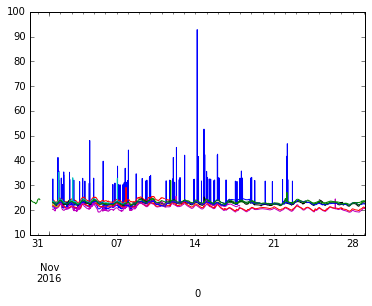

In [126]:
# merge all timeseries into the same data frame
dfs = temperatures.values()
current = dfs[0]
for df in dfs[1:]:
    current = current.merge(df, how='outer',left_index=True, right_index=True)
print len(current)
current.plot(legend=False)

In [127]:
df = current.copy()

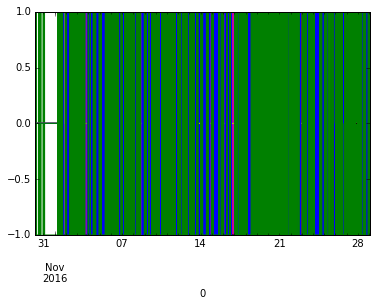

In [128]:
# compute whether or not temperature going up or not
diffs = df.interpolate(method='time').diff(axis=0)
diffs[diffs > 0] = 1
diffs[diffs < 0] = -1
diffs = diffs.fillna(0)
diffs.plot(legend=False)

In [129]:
diffs.tail()

,1706,1702,1632,1630,1712,1627,1629,1628,1716,1713,1631,1707,1715,1624,1709,1622
0,,,,,,,,,,,,,,,,
2016-11-29 02:00:00,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0
2016-11-29 02:05:00,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0
2016-11-29 02:10:00,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0
2016-11-29 02:15:00,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0
2016-11-29 02:20:00,0.0,0.0,0.0,0.0,-1.0,0.0,1.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0


In [120]:
diffs.to_csv("idea1.csv",sep="\t",header=True,index=False)